In [1]:
import json
from datetime import datetime
import itertools
from nltk.stem.lancaster import LancasterStemmer
import re
import nltk

In [2]:
def make_wf_df(dicts,names):
    word_lists = [list(d.keys()) for d in dicts]
    all_words = set(itertools.chain.from_iterable(word_lists))
    df = pd.DataFrame(None, index =  all_words)
    for i, d in enumerate(dicts):
        col = [d[w] if w in d else 0 for w in all_words]
        df[names[i]] = col
    return df

In [7]:
def remove_quotes(t_in):
    t_in= re.sub('“','',t_in)
    t_in= re.sub('”','',t_in)
    t_in= re.sub('"','',t_in)
    return t_in

## Explore Stem/Tokenize

In [3]:
from nltk.probability import FreqDist
import collections
import pandas as pd

In [4]:
def tokenize_text (file):
    with open(file,'r') as f:
        text = f.read()
    f.close()
    return tokenize_stem(text)

In [8]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+|')
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

def tokenize_stem(text):
    text = remove_quotes(text)
    sent_tokenize_list = sent_tokenize(text)
    tokens = []
    for sent in sent_tokenize_list:
        tokens+=word_tokenize(sent)
        
    tokens=[t.lower() for t in tokens]
    tokens=[t for t in tokens if t not in stopwords]
    tokens = [porter_stemmer.stem(t) for t in tokens]
    
    tokens = [re.sub(r"\W|\d","",t) for t in tokens]
    
    tokens = list(filter(None,tokens))
    
    tokens=[t for t in tokens if t not in stopwords]
    
    return tokens
    

In [9]:
fd_bb = FreqDist(tokenize_text('data/breitbart_pol_feb_20_26.txt'))
fd_nyt = FreqDist(tokenize_text('data/nyt_pol_feb_20_26.txt'))
fd_hp = FreqDist(tokenize_text('data/huffpost_pol_feb_20_26.txt'))
fd_fox = FreqDist(tokenize_text('data/fox_pol_feb_20_26.txt'))

### Measure Distances

In [10]:
import numpy as np

In [11]:
freq_dists = [fd_bb, fd_nyt, fd_hp,fd_fox]
names = ["breitbart","NYT","HuffPost","Fox"]

In [12]:
df = make_wf_df(freq_dists,names)

In [13]:
def distance(a,b,norm = 2):
    return np.linalg.norm(a-b,norm)

In [14]:
def print_distances(df,norm,measure_name):
    print("Distance Measure:", measure_name)
    for i in range(df.shape[1]):
        for j in range(i+1,df.shape[1]):
            #print(cos_similarity(df[df.columns[i]],df[df.columns[j]]),": ",df.columns[i],"-",df.columns[j])
            print(distance(df[df.columns[i]],df[df.columns[j]],norm),": ",df.columns[i],"-",df.columns[j])
            

In [15]:
print_distances(df,2,"Euclidian Norm (Freq)")

Distance Measure: Euclidian Norm (Freq)
881.293935075 :  breitbart - NYT
850.730862259 :  breitbart - HuffPost
408.674687251 :  breitbart - Fox
1012.26083595 :  NYT - HuffPost
845.706804986 :  NYT - Fox
763.554844134 :  HuffPost - Fox


In [16]:
source_totals = df.sum(0)

In [17]:
df_prob = df/source_totals

In [18]:
print_distances(df_prob,2,"Euclidian Norm (Prob)")

Distance Measure: Euclidian Norm (Prob)
0.0357741012382 :  breitbart - NYT
0.0171960085738 :  breitbart - HuffPost
0.0194991199599 :  breitbart - Fox
0.0342315188137 :  NYT - HuffPost
0.0348491146819 :  NYT - Fox
0.0178636189113 :  HuffPost - Fox


In [20]:
df_most = df.copy()
df_most["total"] = df_most.sum(1)
df_most.sort_values(by="total",ascending = False,inplace = True)

In [21]:
df_most = df_most.iloc[0:15]

In [22]:
df_most

,breitbart,NYT,HuffPost,Fox,total
trump,236,316,563,367,1482
said,172,368,403,245,1188
presid,146,142,227,195,710
mr,3,675,12,8,698
would,76,118,269,115,578
state,74,128,230,107,539
hous,74,147,154,112,487
new,61,154,157,80,452
time,76,170,138,67,451
one,82,94,180,79,435


In [23]:
df_sub = df.drop(['mr'])

In [24]:
print_distances(df_sub,2,"Euclidian Norm (Freq)")

Distance Measure: Euclidian Norm (Freq)
570.171026973 :  breitbart - NYT
850.683254802 :  breitbart - HuffPost
408.644099431 :  breitbart - Fox
764.920257282 :  NYT - HuffPost
519.933649613 :  NYT - Fox
763.544366753 :  HuffPost - Fox


In [25]:
df_sub_prob = df_prob.drop(['mr'])

In [26]:
print_distances(df_sub_prob,2,"Euclidian Norm (Freq)")

Distance Measure: Euclidian Norm (Freq)
0.0230900105348 :  breitbart - NYT
0.0171954132433 :  breitbart - HuffPost
0.0194977654054 :  breitbart - Fox
0.0208076513569 :  NYT - HuffPost
0.0219164432371 :  NYT - Fox
0.0178634082943 :  HuffPost - Fox


In [27]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [28]:
def plot_mf_hist(df):
    plt.rcParams['figure.figsize'] = (10, 10)
    ind = np.arange(len(df_most))
    width = 0.2
    colors = ["red", "blue", "green", "yellow"]
    fig, ax = plt.subplots()
    for i in range(len(df.columns)-1):
        col_name = df.columns[i]
        ax.barh(ind + width*(i-1), df[col_name], width, color=colors[i], label=col_name)

    ax.set(yticks=ind + width, yticklabels=df.index, ylim=[2*width - 1, len(df)])
    ax.legend()
    plt.show()

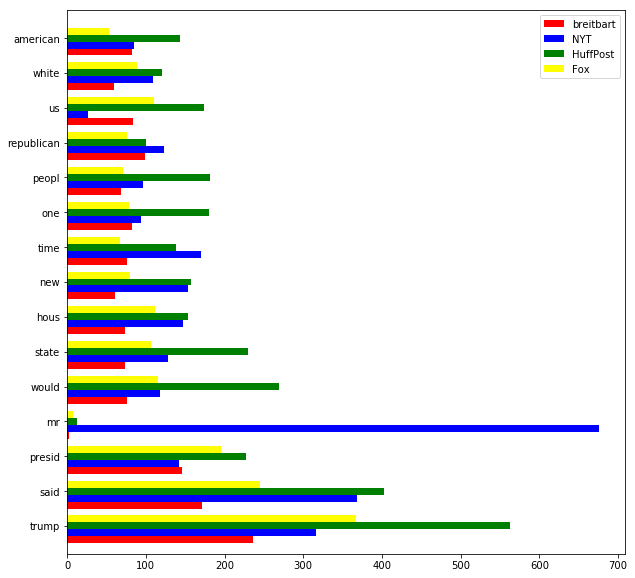

In [29]:
plot_mf_hist(df_most)